In [1]:
# importing dependencies
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

# For model building
from sklearn.model_selection import train_test_split, cross_val_score

# Models
from sklearn.ensemble import RandomForestRegressor

## This notebook will be used for building a random forest decision tree (python)

In [2]:
# Load in the data
weather = pd.read_csv("~/Projects/NiceRide/Weather_data/01012010_12312017.csv") # Weather data

temp = []
for x in [2010 + x for x in range(5)] :
    x = pd.read_csv("~/Projects/NiceRide/Nice_Ride_data/"+str(x)+"/NiceRide_trip_history_"+str(x)+".csv")
    temp.append(x)
    nr = pd.concat(temp)

In [3]:
weather['DATE'] = weather['DATE'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))

nr['Start_date'] = nr['Start_date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
nr['End_date'] = nr['End_date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

Correcting missing data in the weather dataframe

In [4]:
# Changing TAVG-NAN values to the mean of the TMAX and TMIN
weather = weather.fillna(value={'TAVG': weather[weather.TAVG.isna()][['TMAX', 'TMIN']]
                                .agg("mean", axis="columns")})

### Preparing the data to be used for the model

In [5]:
# Resampling our NR data so it takes the start date and Total duration, returns a count of rides per day 'daily_totals'

daily_totals = nr[['Start_date', 'duration']].resample('D', on='Start_date').count()
daily_totals = daily_totals.drop('Start_date', axis=1)
daily_totals = daily_totals.reset_index()
daily_totals = daily_totals.rename(index=str, columns={"duration": "daily_count",'Start_date':'DATE'})

In [6]:
print(daily_totals.head())
print(daily_totals.describe())

        DATE  daily_count
0 2010-06-07            1
1 2010-06-08            1
2 2010-06-09            5
3 2010-06-10           94
4 2010-06-11          285
       daily_count
count  1610.000000
mean    812.611801
std     873.285190
min       0.000000
25%       0.000000
50%     622.000000
75%    1385.750000
max    4471.000000


In [7]:
nr.keys()

Index(['Start_date', 'Start_name', 'Start_id', 'End_date', 'End_name',
       'End_id', 'duration', 'account'],
      dtype='object')

In [8]:
daily_means = nr[['Start_date', 'duration']].resample('D', on='Start_date').mean()
daily_means = daily_means.reset_index()
daily_means = daily_means.rename(index=str, columns={"duration": "daily_mean",'Start_date':'DATE'})

The daily totals DataFrame looks good

In [9]:
print(weather.keys())
# The weather station and name won't be necessary or add anything to our analysis
weather = weather.drop(['STATION', 'NAME'], axis=1)

Index(['STATION', 'NAME', 'DATE', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG',
       'TMAX', 'TMIN'],
      dtype='object')


In [10]:
weather.head()

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
0,2010-01-01,8.95,0.0,0.0,9,-1.5,6,-9
1,2010-01-02,4.03,0.0,0.0,9,-7.0,1,-15
2,2010-01-03,2.91,0.0,0.0,9,-3.5,7,-14
3,2010-01-04,5.59,0.0,0.0,9,-1.5,7,-10
4,2010-01-05,3.13,0.0,0.0,9,0.5,10,-9


In [11]:
temp = weather.merge(daily_totals, how='outer',on='DATE')
temp = temp.merge(daily_means, how='outer',on='DATE')
temp.info()
temp.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 2921
Data columns (total 10 columns):
DATE           2922 non-null datetime64[ns]
AWND           2922 non-null float64
PRCP           2922 non-null float64
SNOW           2922 non-null float64
SNWD           2922 non-null int64
TAVG           2922 non-null float64
TMAX           2922 non-null int64
TMIN           2922 non-null int64
daily_count    1610 non-null float64
daily_mean     1016 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 251.1 KB


,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,daily_count,daily_mean
0,2010-01-01,8.95,0.0,0.0,9,-1.5,6,-9,NaN,NaN
1,2010-01-02,4.03,0.0,0.0,9,-7.0,1,-15,NaN,NaN
2,2010-01-03,2.91,0.0,0.0,9,-3.5,7,-14,NaN,NaN
3,2010-01-04,5.59,0.0,0.0,9,-1.5,7,-10,NaN,NaN
4,2010-01-05,3.13,0.0,0.0,9,0.5,10,-9,NaN,NaN


In [12]:
# Notice how the count of DCOUNT varies from what the other columns have
features = temp.fillna(value=0,axis=0) # Where we don't have a daily count (Dcount) fill this with zeros instead
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 2921
Data columns (total 10 columns):
DATE           2922 non-null datetime64[ns]
AWND           2922 non-null float64
PRCP           2922 non-null float64
SNOW           2922 non-null float64
SNWD           2922 non-null int64
TAVG           2922 non-null float64
TMAX           2922 non-null int64
TMIN           2922 non-null int64
daily_count    2922 non-null float64
daily_mean     2922 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 251.1 KB


In [13]:
features.head()

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,daily_count,daily_mean
0,2010-01-01,8.95,0.0,0.0,9,-1.5,6,-9,0.0,0.0
1,2010-01-02,4.03,0.0,0.0,9,-7.0,1,-15,0.0,0.0
2,2010-01-03,2.91,0.0,0.0,9,-3.5,7,-14,0.0,0.0
3,2010-01-04,5.59,0.0,0.0,9,-1.5,7,-10,0.0,0.0
4,2010-01-05,3.13,0.0,0.0,9,0.5,10,-9,0.0,0.0


This next section will change our date column from dtype datetime into seperate numerical relevant date colummns

In [14]:
features['YEAR'] = features['DATE'].dt.year
features['MONTH'] = features['DATE'].dt.month
features['DAY'] = features['DATE'].dt.day

In [15]:
features.head() # Three new, seperate, columns that identify year, month, day

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,daily_count,daily_mean,YEAR,MONTH,DAY
0,2010-01-01,8.95,0.0,0.0,9,-1.5,6,-9,0.0,0.0,2010,1,1
1,2010-01-02,4.03,0.0,0.0,9,-7.0,1,-15,0.0,0.0,2010,1,2
2,2010-01-03,2.91,0.0,0.0,9,-3.5,7,-14,0.0,0.0,2010,1,3
3,2010-01-04,5.59,0.0,0.0,9,-1.5,7,-10,0.0,0.0,2010,1,4
4,2010-01-05,3.13,0.0,0.0,9,0.5,10,-9,0.0,0.0,2010,1,5


In [16]:
# Create a weekday variable column Mon = 0, Sun = 6
features['WEND'] = features['DATE'].dt.weekday

In [17]:
# Adjust WEND column to be catagorical; If it's a weekday WEND = 0 else if weekend WEND = 1
features['WEND'] = features['WEND'].apply(lambda x:1 if x>4 else 0)
features.head()

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,daily_count,daily_mean,YEAR,MONTH,DAY,WEND
0,2010-01-01,8.95,0.0,0.0,9,-1.5,6,-9,0.0,0.0,2010,1,1,0
1,2010-01-02,4.03,0.0,0.0,9,-7.0,1,-15,0.0,0.0,2010,1,2,1
2,2010-01-03,2.91,0.0,0.0,9,-3.5,7,-14,0.0,0.0,2010,1,3,1
3,2010-01-04,5.59,0.0,0.0,9,-1.5,7,-10,0.0,0.0,2010,1,4,0
4,2010-01-05,3.13,0.0,0.0,9,0.5,10,-9,0.0,0.0,2010,1,5,0


In [18]:
features['SPRING'] = features['MONTH'].apply(lambda x:1 if x>= 4 and x <= 6 else 0)
features['SUMMER'] = features['MONTH'].apply(lambda x:1 if x >= 7 and x <= 9 else 0)
features.head()

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,daily_count,daily_mean,YEAR,MONTH,DAY,WEND,SPRING,SUMMER
0,2010-01-01,8.95,0.0,0.0,9,-1.5,6,-9,0.0,0.0,2010,1,1,0,0,0
1,2010-01-02,4.03,0.0,0.0,9,-7.0,1,-15,0.0,0.0,2010,1,2,1,0,0
2,2010-01-03,2.91,0.0,0.0,9,-3.5,7,-14,0.0,0.0,2010,1,3,1,0,0
3,2010-01-04,5.59,0.0,0.0,9,-1.5,7,-10,0.0,0.0,2010,1,4,0,0,0
4,2010-01-05,3.13,0.0,0.0,9,0.5,10,-9,0.0,0.0,2010,1,5,0,0,0


In [19]:
# Random forests can't use datetime objects
features = features.drop('DATE', axis=1)

In [20]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 2921
Data columns (total 15 columns):
AWND           2922 non-null float64
PRCP           2922 non-null float64
SNOW           2922 non-null float64
SNWD           2922 non-null int64
TAVG           2922 non-null float64
TMAX           2922 non-null int64
TMIN           2922 non-null int64
daily_count    2922 non-null float64
daily_mean     2922 non-null float64
YEAR           2922 non-null int64
MONTH          2922 non-null int64
DAY            2922 non-null int64
WEND           2922 non-null int64
SPRING         2922 non-null int64
SUMMER         2922 non-null int64
dtypes: float64(6), int64(9)
memory usage: 365.2 KB


In [21]:
# Seperating our data sets
winter_features = features[features['daily_count'] == 0].reset_index(drop=True)

# Need to drop all days where there where no rides taken (Dcount = 0)
features = features[features['daily_count'] != 0].reset_index(drop=True)

In [22]:
features.describe()

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,daily_count,daily_mean,YEAR,MONTH,DAY,WEND,SPRING,SUMMER
count,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000
mean,8.672697,0.119636,0.023327,0.097441,62.936024,72.154528,53.816929,1287.701772,2422.691088,2012.113189,7.257874,15.840551,0.285433,0.360236,0.452756
std,3.565801,0.348790,0.286128,0.720805,13.741593,14.692002,13.367336,772.370350,11890.524067,1.355879,2.043477,8.850269,0.451843,0.480305,0.498008
min,0.890000,0.000000,0.000000,0.000000,8.000000,19.000000,-3.000000,1.000000,11.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,6.040000,0.000000,0.000000,0.000000,53.000000,62.000000,44.000000,691.750000,950.090695,2011.000000,6.000000,8.000000,0.000000,0.000000,0.000000
50%,8.280000,0.000000,0.000000,0.000000,65.750000,76.000000,56.000000,1212.500000,1227.514015,2012.000000,7.000000,16.000000,0.000000,0.000000,0.000000
75%,10.960000,0.032500,0.000000,0.000000,74.000000,83.000000,64.000000,1652.250000,1676.253944,2013.000000,9.000000,24.000000,1.000000,1.000000,1.000000
max,23.710000,4.130000,6.400000,8.000000,91.000000,103.000000,81.000000,4471.000000,330526.000000,2014.000000,11.000000,31.000000,1.000000,1.000000,1.000000


DCOUNT shows Minimum of at least 1, and the

I'm concerned why month shows min 1; there shouldn't be any data for January. Time to investigate further

In [23]:
features[features.MONTH == 1]

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,daily_count,daily_mean,YEAR,MONTH,DAY,WEND,SPRING,SUMMER
585,10.29,0.28,0.0,2,31.5,39,24,1.0,106.0,2013,1,10,0,0,0


In [24]:
#features = features[features.MONTH != 1]

In [25]:
type(features.MONTH)

pandas.core.series.Series

In [26]:
#features[features['daily_count'] <= 5]

Data looks good!

### Features, Targets, and converting Data in Arrays (optimizes performance)

In [27]:
# Saving the target/label variable and removing from features Dataframe
target = features.daily_count.values
feat = features.drop('daily_count', axis=1).values

# Saving the feature names for future use
feature_names = list(features.drop('daily_count', axis=1).columns)

In [28]:
# Splitting the data into training and test sets
X, X_test, y, y_test = train_test_split(feat, target, test_size=.25, random_state=42)

Inspecting the shape of the features and labels

In [29]:
print('Training Features shape', X.shape)
print('Training labels shape', y.shape)

print('Testing Features shape', X_test.shape)
print('Testing labels shape', y_test.shape)

Training Features shape (762, 14)
Training labels shape (762,)
Testing Features shape (254, 14)
Testing labels shape (254,)


## Establishing a baseline

Need to find what a good baseline would be

In [30]:
'''
Insert baseline creation code here
'''

'\nInsert baseline creation code here\n'

## Training the data

In [31]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators=75, random_state=42)

rf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

## Making predictions on the test set

In [32]:
predictions = rf.predict(X_test)

## Assessing the performance of our RandomForestRegressor

This is the r2 score

In [33]:
cv_r2 = cross_val_score(rf, X, y, cv=10)
print(cv_r2)
print(np.mean(cv_r2))

[ 0.86112243  0.87499584  0.87492266  0.81255868  0.88620404  0.85463353
  0.79882584  0.84642917  0.87108591  0.70712746]
0.838790554806


In [34]:
cv_negMSElog_error = cross_val_score(rf, X, y, scoring='neg_mean_squared_log_error', cv=5)
print(cv_negMSElog_error)
print(np.mean(cv_negMSElog_error))

[-0.62626211 -0.24804927 -0.32165956 -0.05955331 -0.25407369]
-0.301919589101


In [35]:
errors = abs(predictions - y_test)

print('Mean Absolute Error: ', round(np.mean(errors), 2))

Mean Absolute Error:  207.92


In [36]:
# Calculating the Mean Absolute Percentage Error (MAPE)
mape = 100 * (errors / y_test)

accuracy = 100 - np.mean(mape)
print('Accuracy: ', np.round(accuracy, 2), '%')

Accuracy:  -28.09 %


In [37]:
(errors == y_test).mean()

0.0

In [38]:
# Mean Absolute Square

In [39]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: YEAR                 Importance: 0.4
Variable: TMAX                 Importance: 0.34
Variable: daily_mean           Importance: 0.06
Variable: PRCP                 Importance: 0.04
Variable: TAVG                 Importance: 0.03
Variable: MONTH                Importance: 0.03
Variable: AWND                 Importance: 0.02
Variable: TMIN                 Importance: 0.02
Variable: DAY                  Importance: 0.02
Variable: WEND                 Importance: 0.02
Variable: SUMMER               Importance: 0.01
Variable: SNOW                 Importance: 0.0
Variable: SNWD                 Importance: 0.0
Variable: SPRING               Importance: 0.0


## Visualizing the features and predictions

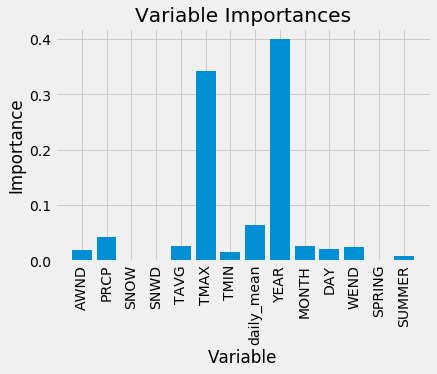

In [40]:
# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_names, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

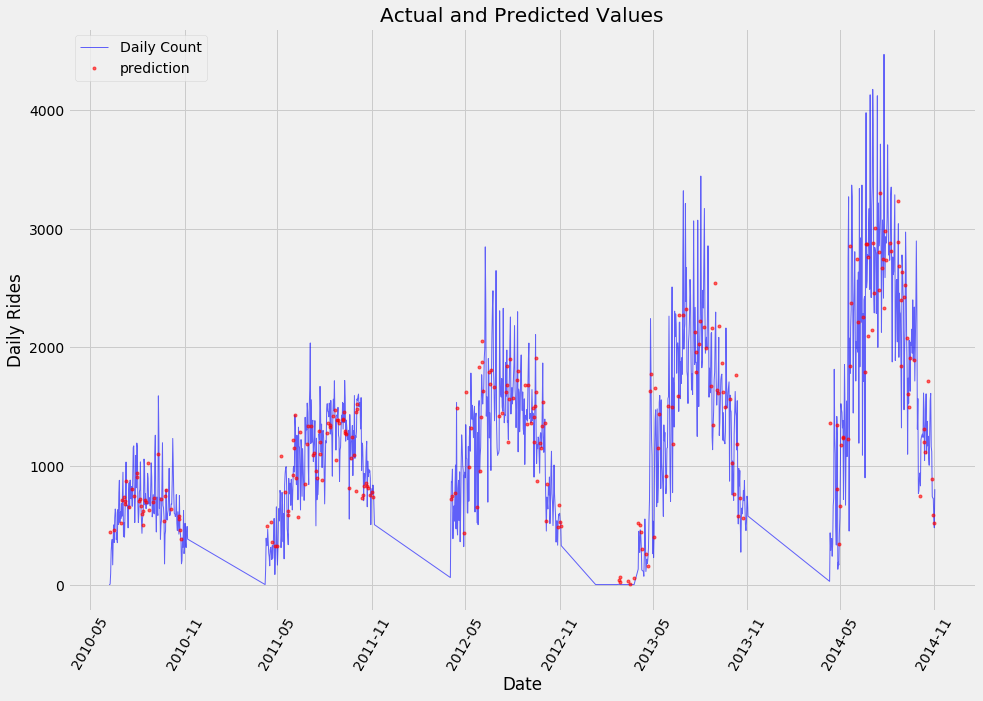

In [41]:
# Dates of training values
days = feat[:, feature_names.index('DAY')]
months = feat[:, feature_names.index('MONTH')]
years = feat[:, feature_names.index('YEAR')]

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [dt.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'DCOUNT': target})

# Dates of predictions
months = X_test[:, feature_names.index('MONTH')]
days = X_test[:, feature_names.index('DAY')]
years = X_test[:, feature_names.index('YEAR')]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convert to datetime objects
test_dates = [dt.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})

# Plot the actual values
plt.figure(figsize=(14.5,10))
plt.plot(true_data['date'], true_data['DCOUNT'], 'b', label = 'Daily Count', linewidth=1, alpha=.6)

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction', markersize=3, alpha=.6)
plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel('Daily Rides'); plt.title('Actual and Predicted Values');

In [42]:
print(features.TMAX.values.shape)
print(target.shape)
print(X_test[:,5].shape) # This is the shape of our TMAX variable in the feature test set
print(predictions.shape)

(1016,)
(1016,)
(254,)
(254,)


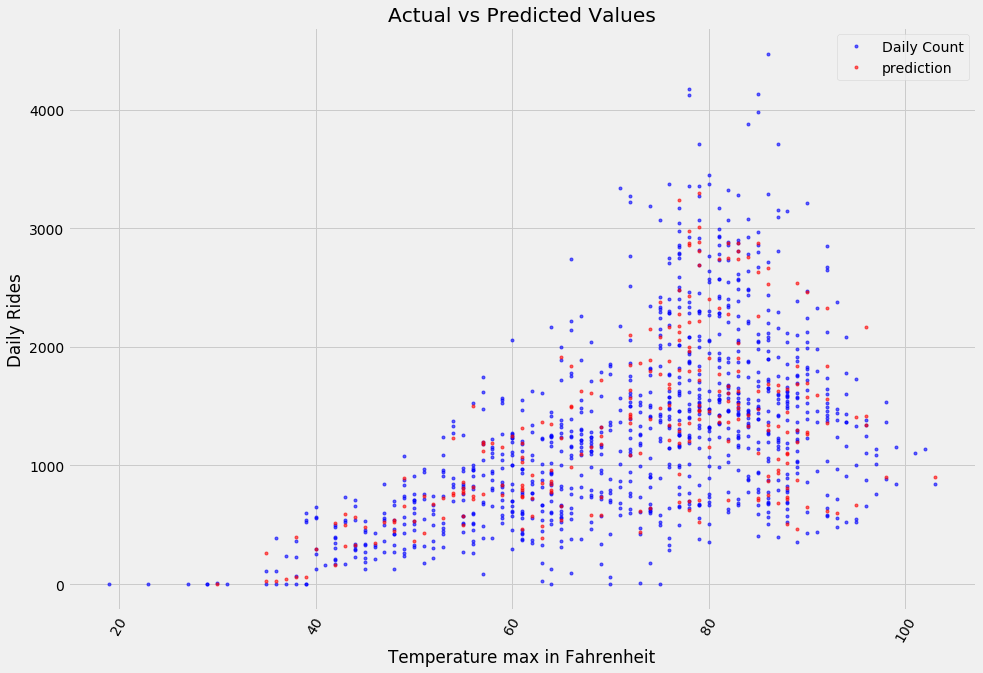

In [43]:
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'TMAX': features.TMAX.values, 'DCOUNT': target})

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'TMAX': X_test[:,5], 'prediction': predictions})

# Plot the actual values and predicted values
plt.figure(figsize=(14.5,10))
plt.plot(true_data['TMAX'], true_data['DCOUNT'], 'bo', label = 'Daily Count', markersize=3, alpha=.6)
plt.plot(predictions_data['TMAX'], predictions_data['prediction'], 'ro', label = 'prediction', markersize=3, alpha=.6)

plt.xticks(rotation = '60'); 
plt.legend()
plt.xlabel('Temperature max in Fahrenheit'); plt.ylabel('Daily Rides'); plt.title('Actual vs Predicted Values');

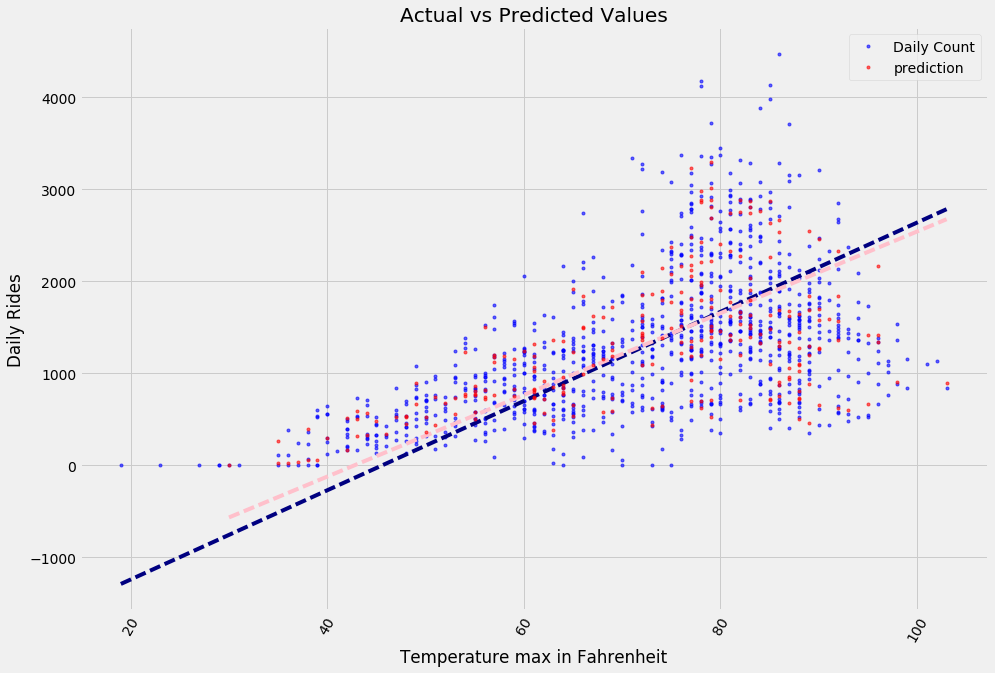

In [44]:
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'TMAX': features.TMAX.values, 'daily_count': target}) 

# Plot the actual values and predicted values
plt.figure(figsize=(14.5,10))
plt.plot(true_data['TMAX'], true_data['daily_count'], 'bo', label = 'Daily Count', markersize=3, alpha=.6)

x = sorted(true_data['TMAX'].values) 
y = sorted(true_data['daily_count'].values)
fit = np.polyfit(x, y, 1) 
fit_fn = np.poly1d(fit) 
plt.plot(x, fit_fn(x), '--k', color='navy')

x = sorted(predictions_data['TMAX'].values) 
y = sorted(predictions_data['prediction'].values)
fit = np.polyfit(x, y, 1) 
fit_fn = np.poly1d(fit) 
plt.plot(x, fit_fn(x), '--k', color='pink')

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'TMAX': X_test[:,5], 'prediction': predictions})

# Plot the actual values and predicted values
plt.plot(predictions_data['TMAX'], predictions_data['prediction'], 'ro', label = 'prediction', markersize=3, alpha=.6)

plt.xticks(rotation = '60'); 
plt.legend()
plt.xlabel('Temperature max in Fahrenheit'); plt.ylabel('Daily Rides'); plt.title('Actual vs Predicted Values');